In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, concatenate, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

c:\Users\Seif\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")

Path to dataset files: C:\Users\Seif\.cache\kagglehub\datasets\anshtanwar\pets-facial-expression-dataset\versions\11


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers


def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same', weight_decay=0.00004):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,
                      use_bias=False,
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    return x


def inception_a(x):
    branch1x1 = conv_bn_relu(x, 64, (1, 1))

    branch5x5 = conv_bn_relu(x, 48, (1, 1))
    branch5x5 = conv_bn_relu(branch5x5, 64, (5, 5))

    branch3x3dbl = conv_bn_relu(x, 64, (1, 1))
    branch3x3dbl = conv_bn_relu(branch3x3dbl, 96, (3, 3))
    branch3x3dbl = conv_bn_relu(branch3x3dbl, 96, (3, 3))

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv_bn_relu(branch_pool, 32, (1, 1))

    return layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=3)


def reduction_a(x):
    branch3x3 = conv_bn_relu(x, 384, (3, 3), strides=(2, 2), padding='valid')

    branch3x3dbl = conv_bn_relu(x, 64, (1, 1))
    branch3x3dbl = conv_bn_relu(branch3x3dbl, 96, (3, 3))
    branch3x3dbl = conv_bn_relu(branch3x3dbl, 96, (3, 3), strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    return layers.concatenate([branch3x3, branch3x3dbl, branch_pool], axis=3)


def inception_b(x):
    branch1x1 = conv_bn_relu(x, 192, (1, 1))

    branch7x7 = conv_bn_relu(x, 128, (1, 1))
    branch7x7 = conv_bn_relu(branch7x7, 128, (1, 7))
    branch7x7 = conv_bn_relu(branch7x7, 192, (7, 1))

    branch7x7dbl = conv_bn_relu(x, 128, (1, 1))
    branch7x7dbl = conv_bn_relu(branch7x7dbl, 128, (7, 1))
    branch7x7dbl = conv_bn_relu(branch7x7dbl, 128, (1, 7))
    branch7x7dbl = conv_bn_relu(branch7x7dbl, 128, (7, 1))
    branch7x7dbl = conv_bn_relu(branch7x7dbl, 192, (1, 7))

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv_bn_relu(branch_pool, 192, (1, 1))

    return layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=3)


def reduction_b(x):
    branch3x3 = conv_bn_relu(x, 192, (1, 1))
    branch3x3 = conv_bn_relu(branch3x3, 320, (3, 3), strides=(2, 2), padding='valid')

    branch7x7x3 = conv_bn_relu(x, 192, (1, 1))
    branch7x7x3 = conv_bn_relu(branch7x7x3, 192, (1, 7))
    branch7x7x3 = conv_bn_relu(branch7x7x3, 192, (7, 1))
    branch7x7x3 = conv_bn_relu(branch7x7x3, 192, (3, 3), strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    return layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=3)


def inception_c(x):
    branch1x1 = conv_bn_relu(x, 320, (1, 1))

    branch3x3 = conv_bn_relu(x, 384, (1, 1))
    branch3x3_1 = conv_bn_relu(branch3x3, 384, (1, 3))
    branch3x3_2 = conv_bn_relu(branch3x3, 384, (3, 1))
    branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2], axis=3)

    branch3x3dbl = conv_bn_relu(x, 448, (1, 1))
    branch3x3dbl = conv_bn_relu(branch3x3dbl, 384, (3, 3))
    branch3x3dbl_1 = conv_bn_relu(branch3x3dbl, 384, (1, 3))
    branch3x3dbl_2 = conv_bn_relu(branch3x3dbl, 384, (3, 1))
    branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=3)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv_bn_relu(branch_pool, 192, (1, 1))

    return layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool], axis=3)


def build_inception_v3(input_shape=(299, 299, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = conv_bn_relu(inputs, 32, (3, 3), strides=(2, 2), padding='valid')
    x = conv_bn_relu(x, 32, (3, 3), padding='valid')
    x = conv_bn_relu(x, 64, (3, 3))
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    x = conv_bn_relu(x, 80, (1, 1))
    x = conv_bn_relu(x, 192, (3, 3), padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # 3x Inception-A
    for _ in range(3):
        x = inception_a(x)

    # Reduction-A
    x = reduction_a(x)

    # 4x Inception-B
    for _ in range(4):
        x = inception_b(x)

    # Reduction-B
    x = reduction_b(x)

    # 2x Inception-C
    for _ in range(2):
        x = inception_c(x)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)


In [4]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [5]:
model = build_inception_v3(input_shape=(299, 299, 3), num_classes=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        320 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 20,037,476 (76.44 MB)

 Trainable params: 20,004,708 (76.31 MB)

 Non-trainable params: 32,768 (128.00 KB)

In [6]:
from tensorflow.keras.applications import InceptionV3

# Builtin Model for Comparison
builtin_model = InceptionV3(weights=None, input_shape=(299, 299, 3), classes=4)
builtin_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 21,776,548 (83.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [7]:
model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
)


c:\Users\Seif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 205s 6s/step - accuracy: 0.2740 - loss: 2.3461 - val_accuracy: 0.1667 - val_loss: 2.2137
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.3407 - loss: 2.1850 - val_accuracy: 0.1667 - val_loss: 2.1920
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 205s 6s/step - accuracy: 0.3668 - loss: 2.2124 - val_accuracy: 0.1667 - val_loss: 2.3656
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.3957 - loss: 2.1837 - val_accuracy: 0.1667 - val_loss: 2.8728
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - accuracy: 0.4654 - loss: 2.0383 - val_accuracy: 0.1944 - val_loss: 3.2202
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.4823 - loss: 2.0755 - val_accuracy: 0.2500 - val_loss: 3.5386
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.5358 - loss: 1.9359 - val_accuracy: 0.2500 - val_loss: 3.9514
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - accuracy: 0.5789 - loss: 1.8579 - val_accuracy: 0.1667 - v

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
              precision    recall  f1-score   support

       Angry     0.3846    0.5000    0.4348        10
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.5455    0.3750        11
       happy     0.6667    0.1818    0.2857        11

    accuracy                         0.3421        38
   macro avg     0.3342    0.3068    0.2739        38
weighted avg     0.3769    0.3421    0.3057        38



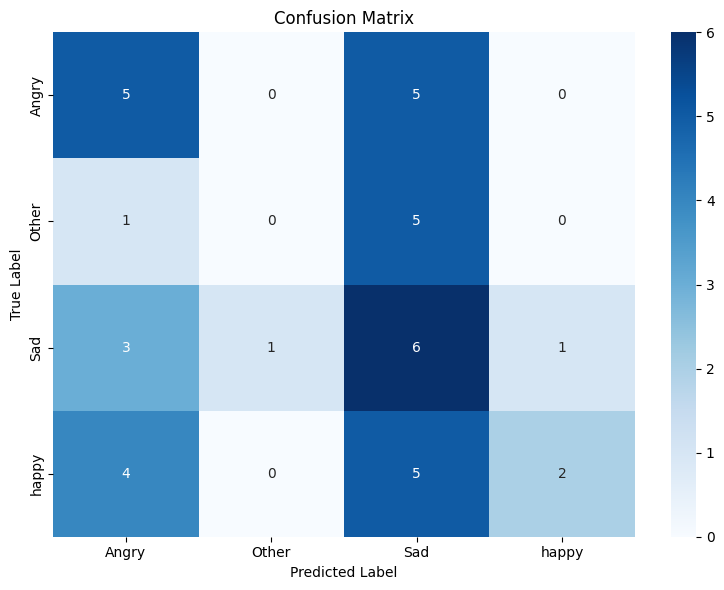

In [8]:


y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
